In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

kn.set_mpl_style()

In [34]:
df0 = kn.data.load_hyades_dataset().query('Member_r19!="other"')

fit = kn.load_stanfit('../scripts/hyades_0_10.pickle')
df_re = kn.reconstruct_df_from_stanfit(fit)


b_c_icrs = np.array([17.13924468, 41.23189102, 13.65416937])
b0 = b_c_icrs
rvec = df0[['x','y','z']].values - b0[None]
r = np.linalg.norm(rvec, axis=1)
df0['r_c']=r
df_cl = df0.loc[r<10].copy().reset_index(drop=True)
df_tails = df0.loc[r>10].copy().reset_index(drop=True)

assert (df_cl['ra'].values-df_re['ra'].values == 0).all()
assert np.allclose(df_cl['dec'].values, df_re['dec'].values)
assert np.allclose(df_cl['parallax'].values, df_re['parallax'].values)

df_cl['mean_pmem'] = df_re['mean_pmem']

fit = kn.load_stanfit('../scripts/hyades_10_m_fixed_v0.pickle')
df_re = kn.reconstruct_df_from_stanfit(fit)
df_tails['mean_pmem'] = df_re['mean_pmem']

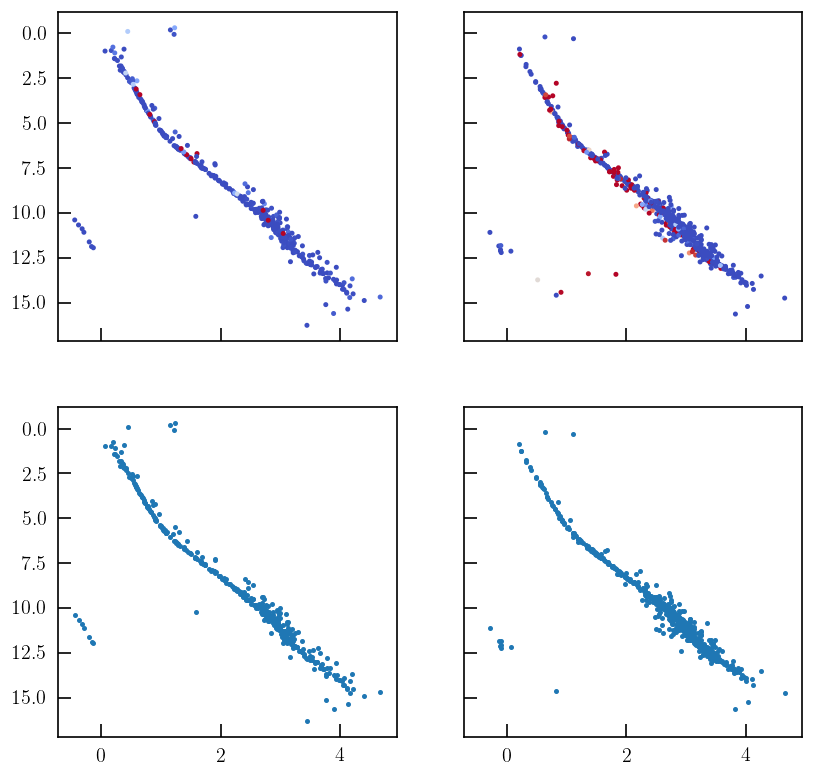

In [91]:
fig, ((ax, ax_tails), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(8, 8), sharex=True, sharey=True,
    gridspec_kw=dict(right=0.9)
)
ax.scatter(
    df_cl["bp_rp"],
    df_cl["phot_g_mean_mag"] + df_cl.g.distmod,
    s=4,
    c=df_cl["mean_pmem"],
    cmap="coolwarm_r",
    vmin=0,
    vmax=1,
)
ax.invert_yaxis()

patches = ax_tails.scatter(
    df_tails["bp_rp"],
    df_tails["phot_g_mean_mag"] + df_tails.g.distmod,
    s=4,
    c=df_tails["mean_pmem"],
    cmap="coolwarm_r",
    vmin=0,
    vmax=1,
)
# plt.colorbar(patches, ax=ax_tails)

for cdf, cax in zip([df_cl, df_tails], (ax3, ax4)):
    memonly = cdf.loc[cdf["mean_pmem"] > 0.5]
    cax.scatter(memonly["bp_rp"], memonly["phot_g_mean_mag"] + memonly.g.distmod, s=4);

    

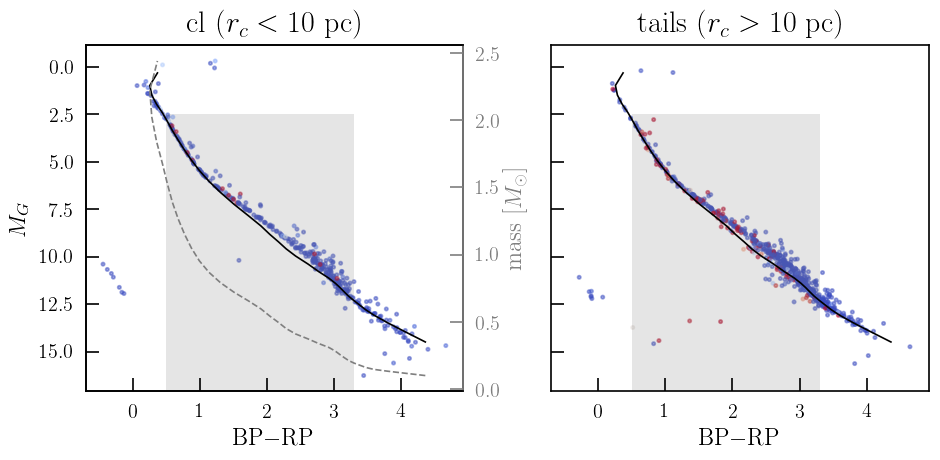

In [137]:
fig, (ax, ax_tails) = plt.subplots(
    1, 2, figsize=(8, 4), sharex=True, sharey=True,
)
ax.scatter(
    df_cl["bp_rp"],
    df_cl["phot_g_mean_mag"] + df_cl.g.distmod,
    s=4,
    c=df_cl["mean_pmem"],
    cmap="coolwarm_r",
    vmin=0,
    vmax=1, alpha=.5
)
ax.invert_yaxis()

patches = ax_tails.scatter(
    df_tails["bp_rp"],
    df_tails["phot_g_mean_mag"] + df_tails.g.distmod,
    s=4,
    c=df_tails["mean_pmem"],
    cmap="coolwarm_r",
    vmin=0,
    vmax=1, alpha=.5
)

hy_track = mist_track.generate(np.logspace(-1,1), np.log10(680e6), 0.24)

for cax in [ax,ax_tails]:
    cax.plot(hy_track['BP_mag']-hy_track['RP_mag'], hy_track['G_mag'],'k-');
    cax.set_xlabel(r'BP$-$RP')

    cax.axvspan(0.5, 3.3, ymax=0.8, alpha=.2, color='gray', linewidth=0)
ax.set_title('cl ($r_c<10$ pc)')
ax_tails.set_title('tails ($r_c>10$ pc)')

axt = ax.twinx()
axt.plot(hy_track['BP_mag']-hy_track['RP_mag'], hy_track['mass'], ls='--', color='tab:gray')
axt.spines["right"].set_edgecolor('tab:gray')
axt.tick_params(axis='y', colors='tab:gray')
axt.set_ylabel(r'mass [$M_\odot$]', color='tab:gray')
ax.set_ylabel(r'$M_G$')
fig.tight_layout()
fig.savefig('../report/plots/cmd-cl-tails.pdf')

In [140]:
df_cl['phot_g_mean_mag'][(np.abs(df_cl['bp_rp']-3.3)<0.1)].describe()

count    21.000000
mean     15.419714
std       0.392022
min      14.701345
25%      15.223361
50%      15.490333
75%      15.702334
max      16.146055
Name: phot_g_mean_mag, dtype: float64

In [141]:
df_tails['phot_g_mean_mag'][(np.abs(df_tails['bp_rp']-3.3)<0.1)].describe()

count    71.000000
mean     16.026468
std       0.932832
min      13.064631
25%      15.536033
50%      16.036228
75%      16.659847
max      18.139645
Name: phot_g_mean_mag, dtype: float64

/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


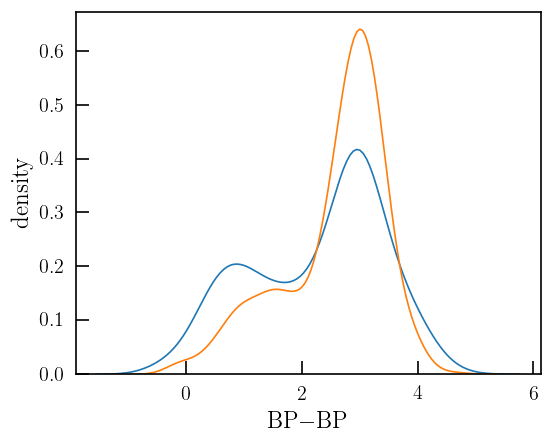

In [128]:
for cdf in [df_cl, df_tails]:
    memonly = cdf.loc[cdf["mean_pmem"] > 0.5]
    x = memonly['bp_rp'].values
    sns.kdeplot(x,)
plt.xlabel('BP$-$BP')
plt.ylabel('density');

In [10]:
from isochrones.mist import MIST_EvolutionTrack

mist_track = MIST_EvolutionTrack()

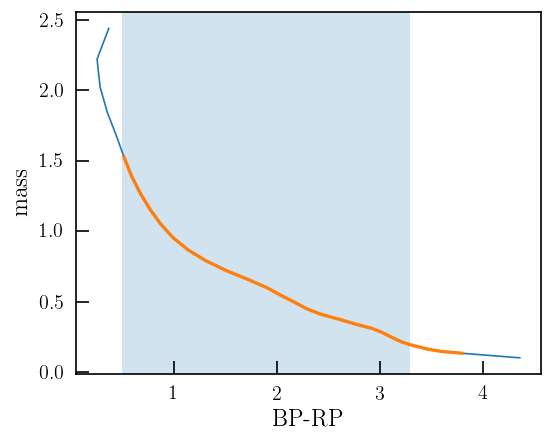

In [129]:
plt.plot(hy_track['BP_mag']-hy_track['RP_mag'], hy_track['mass']);
plt.axvspan(0.5, 3.3, alpha=.2)

x, y = hy_track['BP_mag']-hy_track['RP_mag'], hy_track['mass']
x, y = x[(x>0.5) & (x<4)], y[(x>0.5) & (x<4)]
plt.plot(x, y, lw=2);
from scipy import interpolate
bprp_to_mass = interpolate.interp1d(x, y, fill_value="extrapolate")
plt.xlabel('BP-RP')
plt.ylabel('mass');

In [130]:
bprp_to_mass(0.5), bprp_to_mass(3.3)

(array(1.56134251), array(0.19270899))

In [131]:
cond = (df_cl['bp_rp']>0.5)&(df_cl['bp_rp']<3.3) & (df_cl['mean_pmem']>0.5) & (df_cl['phot_g_mean_mag']+df_cl.g.distmod>2.8)
len(df_cl), (df_cl['bp_rp']>0.5).sum(), cond.sum(), bprp_to_mass(df_cl['bp_rp'][cond]).sum()

(400, 367, 288, 156.6444020433016)

In [132]:
cond = (df_tails['bp_rp']>0.5)&(df_tails['bp_rp']<4) & (df_tails['mean_pmem']>0.5) & (df_tails['phot_g_mean_mag']+df_tails.g.distmod>2.8)
len(df_tails), (df_tails['bp_rp']>0.5).sum(), cond.sum(), bprp_to_mass(df_tails['bp_rp'][cond]).sum()

(703, 683, 587, 238.97066820789348)

In [133]:
from scipy import stats

def betterstep(bins, y, **kwargs):
    """A 'better' version of matplotlib's step function
    
    Given a set of bin edges and bin heights, this plots the thing
    that I wish matplotlib's ``step`` command plotted. All extra
    arguments are passed directly to matplotlib's ``plot`` command.
    
    Args:
        bins: The bin edges. This should be one element longer than
            the bin heights array ``y``.
        y: The bin heights.
        ax (Optional): The axis where this should be plotted.
    
    """
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    ax = kwargs.pop("ax", plt.gca())
    return ax.plot(new_x, new_y, **kwargs)

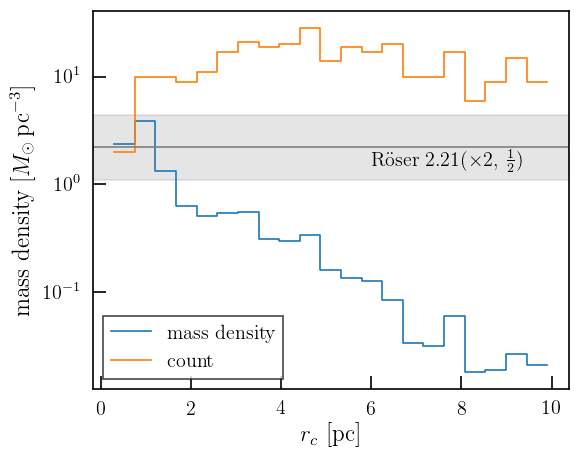

In [134]:
bs=stats.binned_statistic(
    df_cl_good['r_c'],
    bprp_to_mass(df_cl_good['bp_rp']),statistic='sum', bins=21)
bs_log=stats.binned_statistic(
    df_cl_good['r_c'],
    bprp_to_mass(df_cl_good['bp_rp']),statistic='sum', bins=np.logspace(-2,1.2,11))
bs_count=stats.binned_statistic(
    df_cl_good['r_c'],
    bprp_to_mass(df_cl_good['bp_rp']),statistic='count',bins=21)
edges_to_centers = lambda x:(x[1:]+x[:-1])*0.5

massdens = 2.45*bs.statistic/(np.pi*4*edges_to_centers(bs.bin_edges)**2*(bs.bin_edges[1]-bs.bin_edges[0]))
# numdens_err= 2.45*np.sqrt(bsbs.statistic/(np.pi*4*edges_to_centers(bs.bin_edges)**2*(bs.bin_edges[1]-bs.bin_edges[0]))

betterstep(
    bs.bin_edges, massdens, label='mass density'
)
betterstep(
    bs_count.bin_edges,
    bs_count.statistic, label='count'
)
# plt.plot(edges_to_centers(bs_log.bin_edges),
#          2.45*bs_log.statistic/(np.pi*4*edges_to_centers(bs_log.bin_edges)**2*(bs_log.bin_edges[1]-bs_log.bin_edges[0])), 'o-')

plt.yscale('log');
# plt.xscale('log')
plt.axhline(2.21, c='C7');
plt.axhspan(2.21*0.5, 2.21*2, color='C7',alpha=.2)
plt.text(6, 2., r'Röser $2.21 (\times 2,\,\frac{1}{2})$', va='top')

plt.legend(loc='lower left');
plt.xlabel('$r_c$ [pc]')
plt.ylabel(r'mass density [$M_\odot\,\mathrm{pc}^{-3}$]');
plt.tight_layout()
plt.savefig('../report/plots/massdensity-rc.png')